## QuipuSwap Tezos Pool Analysis Tool
#### 1. Select token bellow
#### 2. Increase requests depth if there are needed more than one request to pull all data and you need this trading history
#### 3. Run this cells using Runtime -> Run all

In [1]:
#@title Collecting data and processing data functions
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns

sns.set_style("whitegrid")


def make_deep_requests(url, depth=5, limit=1000, sleep_time=2, stop_id=None):

    last_id = None
    data = pd.DataFrame()

    for counter in tqdm(range(depth)):
        if last_id:
            url += f'&lastId={last_id}'

        try:
            response = requests.get(url)
            new_data = json_normalize(json.loads(response.text))
            data = data.append(new_data)

        except Exception as exception:
            print(exception)
            import pdb; pdb.set_trace()

        last_id = data.id.iloc[-1]

        if len(new_data) < limit:
            break

        if stop_id in data['id'].values:
            break

        time.sleep(sleep_time)

    return data


def process_pool_data(df, token_decimals=6):

    convert = {
        'value.storage.tez_pool': lambda x: float(x) / 1_000_000,
        'value.storage.token_pool': lambda x: float(x) / (10**token_decimals),
        'timestamp': pd.Timestamp
    }

    for column_name, mapper in convert.items():
        df[column_name] = df[column_name].map(mapper)

    df['rate'] = df['value.storage.tez_pool'] / df['value.storage.token_pool']
    df = df.set_index('timestamp')
    return df


def collect_storage_history(smart_contract, depth=1, limit=1000):
    url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history?limit={limit}'
    return make_deep_requests(url, depth=depth)

In [2]:
#@title QuipuSwap contracts (unhide and insert here another QuipuSwap contracts if you want to)

# tokens dict contains:
# 1. QuipuSwap token address (note that this is address of the contract
#        that used to trade, not the FA2/FA1.2 token address)
# 2. Decimals used in this token

tokens = dict(
    hDAO =     ('KT1QxLqukyfohPV5kPkw97Rs6cw1DDDvYgbB', 6),
    WRAP =     ('KT1FG63hhFtMEEEtmBSX2vuFmP87t9E7Ab4t', 8),
    tCow =     ('KT1XQZxsG4pMgcN7q7Nu3XFihsb9mEvqBmAT', 2),
    bDAO =     ('KT1DssMzoSr8fnUUq1WxeSuHfLG4gzS7pgge', 6),
    RSAL =     ('KT1WDe2vJCDqz5euKupppQsioPcakUd45Tfo', 0),
    tCowLP =   ('KT1UEfXGj5Ag73qCdZTk2534SZDT7cd7J8m8', 0),
    STKR =     ('KT1BMEEPX7MWzwwadW3NCSZe9XGmFJ7rs7Dr', 18),
    GUTS =     ('KT1WYQj3HEt3sxdsV4dMLA8RKzUnYAzXgguS', 0),
    Tacoz =    ('KT1VfiExduEkrpM4TbsnAw9QV1VURqaRFGKs', 18),
    token42 =  ('KT1M5H8qkJEzhdC3ZxZ78bSxgmcddrcusbry', 0),
    tSpanish = ('KT1A834QfnWremTQ4tc63s8NKbHzLJVszgxc', 0),
    DeanCoin = ('KT1BAPAVXMuYz63HrF9CGM9Gu8JVYTFpYqao', 6),
    tezos10x = ('KT1A4Sj8TBg4pazMkj226bAAcH6A4iCNQno4', 0),
    sDAO =     ('KT1PrRTVNgxkRgyqqNQvwTiVhd55dqyxXJ6n', 0),
    banana =   ('KT1Sd8jvepChHEHo63owNfjnqgzJEkUWSj9q', 2),
    SHTz =     ('KT1G7Z14RJLKbfu96Hc22bwNL67aykunAGyH', 2),

    sUSD =     ('KT1KFszq8UFCcWxnXuhZPUyHT9FK3gjmSKm6', 6),
    ETHtz =    ('KT1Evsp2yA19Whm24khvFPcwimK6UaAJu8Zo', 18),
    kUSD =     ('KT1K4EwTpbvYN9agJdjpyJm4ZZdhpUNKB3F6', 18),

    wUSDC =    ('KT1U2hs5eNdeCpHouAvQXGMzGFGJowbhjqmo', 6),
    wWETH =    ('KT1DuYujxrmgepwSDHtADthhKBje9BosUs1w', 18),
    RITA =     ('KT1L98jqwZtKUZbcPNxb3pTY7b2WXUGEzn8G', 6),
    MEL =      ('KT1BsDKTXBiYck85fJnoDzedyKKNtMuC9B9h', 6),
    BDoge =    ('KT1Th57AbgJmiZWDny6Ewqd2sx5qSxJwu8ry', 4),
    wMATIC =   ('KT1RsfuBee5o7GtYrdB7bzQ1M6oVgyBnxY4S', 18),

    TTT =      ('KT1WYoYSdHNmNJf9pHWPoHJWDA3bid1NP9SJ', 8),
    SOIL =     ('KT1NXdxJkCiPkhwPvaT9CytFowuUoNcwGM1p', 4),
    BART =     ('KT1WJVYEjLRirPQDSWqfggjqFGn14y9hiCBL', 9),
    NOLA =     ('KT1Fm5fS6VhFyE9wgopXcoQ3Nyb5awLY2sQH', 6),
    wSUSHI =   ('KT1Lotcahh85kp878JCEc1TjetZ2EgqB24vA', 18),
    CVZA =     ('KT1F3BqwEAoa2koYX4Hz7zJ8xfGSxxAGVT8t', 8),
    wDAI =     ('KT1PQ8TMzGMfViRq4tCMFKD2QF5zwJnY67Xn', 18),
    wLINK =    ('KT1Lpysr4nzcFegC9ci9kjoqVidwoanEmJWt', 18),
    tDAO =     ('KT1X6dAh8fwQMkWC9yh4yuvkJaS5NjqY4NvW', 4),
    rugDao =   ('KT1D3tdqrEkcwKkhJso5jmrJiyiaNVWtYiFJ', 2),
    DONTz =    ('KT1FaPEfr2hGTR1d4tN9VikubuSVS1CuuMJX', 2),
    BEEz =     ('KT1A4tYKJDJHrLonvp4qkJpZz5fkoWcAxMxW', 2),
    gDAO =     ('KT198myhugqAVvtNbYgN4sBKMFRYBvprcKHf', 6),
    wPAX =     ('KT1Ca5FGSeFLH3ugstc5p56gJDMPeraBcDqE', 18),
    WEED =     ('KT1TYjt5eLHRx3nQpSfaR94oQ6vehu24vvSQ', 8),
    wBTC =     ('KT1DksKXvCBJN7Mw6frGj6y6F3CbABWZVpj1', 8),
    SEB =      ('KT1S4WyNiYPoYheihysddNh5hojNFdiVBwZL', 2),

    CUU =      ('KT1W1hafYEzQkQLXyRPTxMeG3UaoUSsW7wNR', 2),
    HSK =      ('KT19HJTgEqnmi1cYyq8z2WFtyNTECodfixmj', 2),
    TITz =     ('KT1BNRefGboWR4p2SFwDDTosjnPKPL9hVk3q', 2),
    F15H =     ('KT1CNEgfKrGWtYdWAGG3cyZAUcFFpotmAme9', 2),
    FLAME =    ('KT1Q93ftAUzvfMGPwC78nX8eouL1VzmHPd4d', 6),
    BRR =      ('KT1PmH3JCEo65koqSGGUArKSpbKMN8dJ3BPZ', 6),

    BEEF =     ('KT1BtmMAnmTGHAA9ZV8xPzuwZu4ibL7f5qb3', 6),
    RTT =      ('KT1QoKSXVnvytnkbMLu8Nqh9vH9qPdtvxR6K', 2),

    # description tells: ignore this, just testing do not buy, but you can enable if you want to:
    # boofs =    ('KT1F2uvnfdN6GYKhhCDfb1kt5h9TaeXAbVeh', 2)

    # another with description tells to ignore:
    # Chunk =    ('KT1DiGxvRshVMn2p1KRfew6fnP9hpHT212MX', 8)

    tChicken = ('KT1JzZtBeHDBS9XyEqUc9nZhsqcfeNLxVV1T', 6),
    GSAL =     ('KT1BzNUUjURkTtNhXFkbGtu9fY3Q5scKZrvK', 0),
    sCAS =     ('KT1HhUWkzjmdjFTgNMmGgdNWGb6wwEXA4XCT', 0),
    CRUNCH =   ('KT1RRgK6eXvCWCiEGWhRZCSVGzhDzwXEEjS4', 8),
    Bezos =    ('KT1ETAtdv2PTvXwbGGsWWjnswfagdUc77hiP', 0),
)

In [3]:
#@title Select token
token = "hDAO" #@param ['hDAO', 'WRAP', 'tCow', 'bDAO', 'sDAO', 'tCowLP', 'STKR', 'GUTS', 'Tacoz', 'token42', 'tSpanish', 'DeanCoin', 'tezos10x', 'RSAL', 'banana', 'SHTz', 'sUSD', 'ETHtz', 'kUSD', 'wUSDC', 'wWETH', 'RITA', 'MEL', 'BDoge', 'wMATIC', 'TTT', 'SOIL', 'BART', 'NOLA', 'wSUSHI', 'CVZA', 'wDAI', 'wLINK', 'tDAO', 'rugDao', 'DONTz', 'BEEz', 'gDAO', 'wPAX', 'WEED', 'wBTC', 'SEB', 'CUU', 'HSK', 'TITz', 'F15H', 'FLAME', 'BRR', 'BEEF', 'RTT', 'tChicken', 'GSAL', 'sCAS', 'CRUNCH', 'Bezos']
requests_depth = 1 #@param {type:"integer"}
contract_address = tokens[token][0]
token_decimals = tokens[token][1]

limit = 1000

In [4]:
#@title Requesting data
# Running requests & processing:
data = process_pool_data(
    collect_storage_history(contract_address, depth=requests_depth, limit=limit),
    token_decimals=token_decimals
)

100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


### Plotting price dynamics:
You can change labels/names and colors if you would like

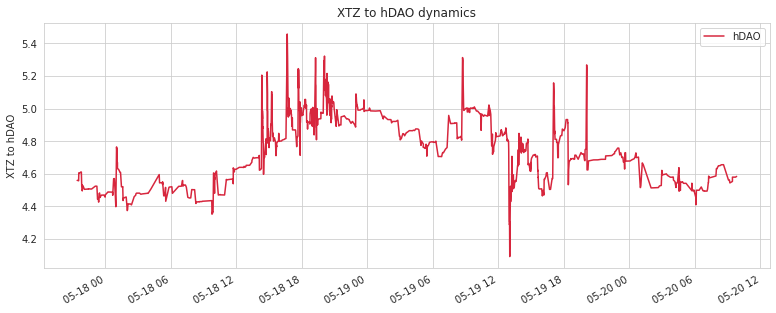

In [5]:
data.rate.rename(f'{token}').plot(color='#D7263D', figsize=(13,5))

plt.xlabel('')
plt.ylabel(f'XTZ to {token}')
plt.legend()
_ = plt.title(f'XTZ to {token} dynamics')

# If you want to save plot, uncomment next line (remove sharp in the beginnig):
# plt.savefig(f'{token}_price_dynamics.png')

### Plotting pools data:
This visualisation is about current liquidity in pools

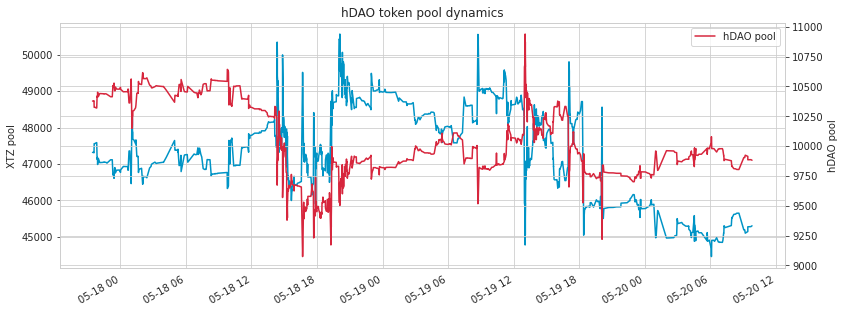

In [6]:
ax1 = data['value.storage.tez_pool'].rename(f'XTZ pool').plot(figsize=(13,5), color='#0094C6')
ax1.set_ylabel('XTZ pool')

ax2 = ax1.twinx()
ax2.set_ylabel(f'{token} pool')

data['value.storage.token_pool'].rename(f'{token} pool').plot(ax=ax2, color='#D7263D')

ax1.set_xlabel("")
plt.legend()
_ = plt.title(f'{token} token pool dynamics')

# If you want to save plot, uncomment next line (remove sharp in the beginnig):
# plt.savefig(f'{token}_pool_dynamics.png')

@ztepler